In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors
import glob

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union

import hoomd
import gsd.hoomd
import freud

import sys
import time
import pickle
import gc
import warnings
import copy
import pathlib

import os
import sys

import signac

from dataclasses import dataclass
from dataclasses_json import dataclass_json

In [2]:
from monk import nb, prep, pair, render, utils, workflow, methods, grid
render.preview_tracer.resize(800, 800)

config = workflow.get_config()

In [3]:
project: signac.Project = signac.get_project(root=config['root'])

# Build local yield stress/strain computation system

In [4]:
for idx, job in enumerate(project.find_jobs({"phi":1.4})):
    print(idx, job.sp)
    sp = job.sp
    doc = job.doc

    sim = hoomd.Simulation(hoomd.device.GPU(), seed=doc['seed'])
    snapshot = gsd.hoomd.open(job.fn('quenched-more.gsd'), 'rb')[0]
    sim.create_state_from_snapshot(snapshot)

    fire = hoomd.md.minimize.FIRE(1e-2, 1e-3, 1.0, 1e-3)
    tree = hoomd.md.nlist.Tree(0.3)
    hertz = pair.bi_hertz(tree)
    nve = hoomd.md.methods.NVE(filter=hoomd.filter.All())
    fire.forces = [hertz]
    fire.methods = [nve]
    break

0 {'N': 32768, 'replica': 4, 'phi': 1.4}


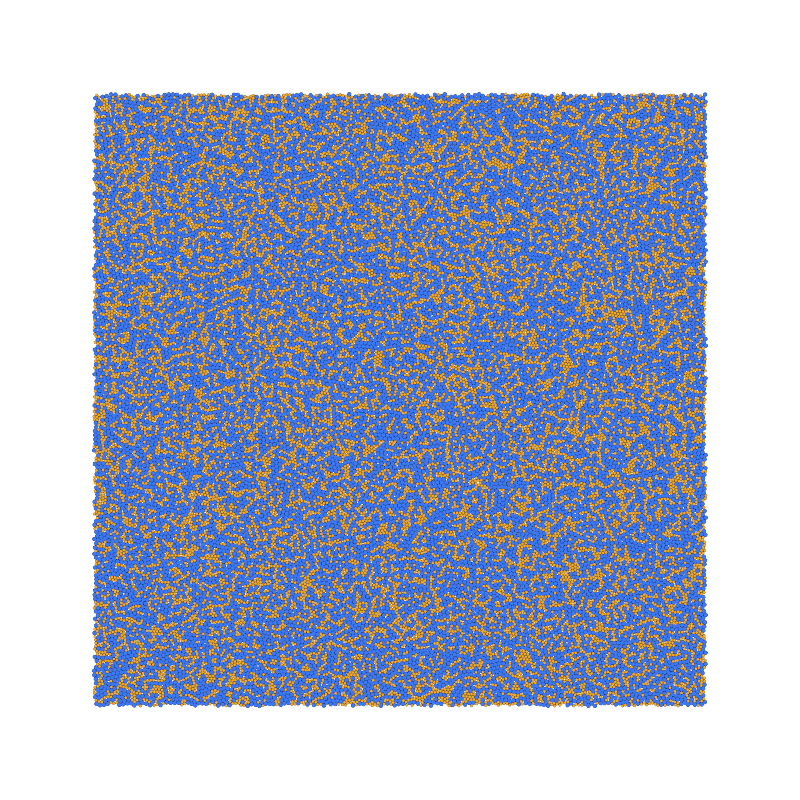

In [5]:
render.render_disk_frame(snapshot, Ly=200.0)

In [6]:
from copy import deepcopy

class ArrayVariant(hoomd.variant.Variant):
    def __init__(self, array):
        self.array = array
        self.__min = np.min(array)
        self.__max = np.max(array)
        self.idx = 0
        hoomd.variant.Variant.__init__(self)

    def __call__(self, timestep):
        if self.idx < len(self.array):
            result = self.array[self.idx]
            self.idx += 1
            return result
        else:
            return self.array[-1]

    def _min(self):
        return self.__min

    def _max(self):
        return self.__max

class SnapCut:

    def __init__(self, snap: gsd.hoomd.Snapshot, query_index, r_free=5.0, r_hard=2.0, angles=None):
        if angles is None:
            self.angles = np.linspace(0.0, 175.0, 36)
        else:
            self.angles = angles
        self.snap = snap
        self.dim = snap.configuration.dimensions
        assert self.dim == 2
        self.r_free = r_free

        r_max = r_free + r_hard
        sep = 2.0*r_max + r_hard
        nlist_query = freud.locality.AABBQuery.from_system(snapshot)
        query_pos = snapshot.particles.position[query_index]
        if len(query_pos.shape) < 2:
            query_pos = query_pos[np.newaxis, :]
        nlist = nlist_query.query(query_pos, {'r_max': r_max}).toNeighborList()

        box = freud.box.Box.from_box(snapshot.configuration.box)

        size = np.sum(nlist.neighbor_counts)
        pos = np.zeros((size, 3))
        typeid = np.zeros(size, dtype=np.int32)
        diameters = np.zeros(size)
        include = np.ravel(np.argwhere(nlist.distances < r_free)).astype(np.uint32)
        exclude = np.ravel(np.argwhere(nlist.distances >= r_free)).astype(np.uint32)
        i = 0
        j = 0
        for head, nn in zip(nlist.segments, nlist.neighbor_counts):
            indices = nlist.point_indices[head:head+nn]
            pos[j:j+nn] = box.wrap(snapshot.particles.position[indices] - query_pos[i])
            typeid[j:j+nn] = snapshot.particles.typeid[indices]
            diameters[j:j+nn] = snapshot.particles.diameter[indices]
            i += 1
            j += nn

        self.pos = pos
        self.nlist = nlist
        self.typeid = typeid
        self.diameters = diameters
        self.include = include
        self.exclude = exclude

    def to_snap(self, index=0, theta=0.0, degrees=True):
        snap = gsd.hoomd.Snapshot()
        head = self.nlist.segments[index]
        nn = self.nlist.neighbor_counts[index]

        Lz = 4.0*self.r_free
        if self.dim == 2:
            Lz = 0

        if degrees:
            theta = np.deg2rad(theta)
        rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

        snap.configuration.dimensions = self.dim
        snap.configuration.box = [4.0*self.r_free + 2, 4.0*self.r_free + 2, 0, 0, 0, 0]

        snap.particles.N = nn
        tmp = self.pos[head:head+nn]
        tmp[:,:2] = np.dot(rot, tmp[:,:2].T).T
        snap.particles.position = tmp
        snap.particles.typeid = self.typeid[head:head+nn]
        snap.particles.diameter = self.diameters[head:head+nn]
        snap.particles.types = self.snap.particles.types
        return snap

    def run_local_strain_test(self, index=0):
        sim = hoomd.Simulation(hoomd.device.CPU(), seed=0)
        snap = hoomd.Snapshot.from_gsd_snapshot(self.to_snap(index), sim.device.communicator)
        head = self.nlist.segments[index]
        nn = self.nlist.neighbor_counts[index]
        try:
            sim.create_state_from_snapshot(snap)
        except:
            sim.state.set_snapshot(snap)

        include = self.include[head:head+nn]
        # exclude = self.exclude[head:head+nn]

        tree = hoomd.md.nlist.Tree(0.3)
        hertz = pair.bi_hertz(tree)
        nve = hoomd.md.methods.NVE(filter=hoomd.filter.Tags(include))
        fire = hoomd.md.minimize.FIRE(1e-2, 1e-4, 1.0, 1e-4)
        fire.forces = [hertz]
        fire.methods = [nve]
        sim.operations.integrator = fire
        sim.run(0)

        # writer = hoomd.write.GSD(filename='test.gsd', trigger=hoomd.trigger.Periodic(10000, 999), mode='wb')
        # sim.operations.writers.append(writer)

        virials = []

        ramp = np.linspace(0, 1, 201)
        len_ramp = len(ramp)

        # angles = np.linspace(0.0, 175.0, 36)
        angles = self.angles
        for theta in angles:
            snap = hoomd.Snapshot.from_gsd_snapshot(self.to_snap(index, theta), sim.device.communicator)
            sim.state.set_snapshot(snap)
            box = sim.state.box
            new_box = deepcopy(box)
            new_box.xy = 0.20
            trigger = methods.AsyncTrigger()
            variant = ArrayVariant(ramp)
            updater = hoomd.update.BoxResize(trigger, box, new_box, variant)
            sim.operations.updaters.append(updater)

            virial_run = np.zeros((len_ramp, 3))
            
            for i in range(len_ramp):
                
                fire.reset()
                while not fire.converged:
                    sim.run(1000)
                sim.always_compute_pressure = True
                sim.run(0)
                virial_run[i] = np.mean(hertz.virials[include][: ,[0,1,3]], axis=0)
                sim.always_compute_pressure = False
                if i < len_ramp - 1:
                    trigger.activate()
                sim.run(0)
            virials.append(virial_run)
            
        return np.array(virials), angles


In [7]:
samples = 10
query_indices = np.random.permutation(snapshot.particles.N)[:samples]
query_indices

array([31055, 15050, 23261,  2327, 24223, 12444, 24396, 22144, 27129,
       19279])

In [8]:
from multiprocessing import Pool

def do_work(index, rcut):
    cut = SnapCut(snapshot, index, r_free=rcut)
    virials, _ = cut.run_local_strain_test()
    
    np.save(f'virials_index-{index}_rcut-{rcut:.1f}.npy', virials)


for rcut in [1.5, 2.5, 3.5, 5.0, 10.0]:
    with Pool(8) as p:
        p.starmap(do_work, zip(query_indices, [rcut]*samples))

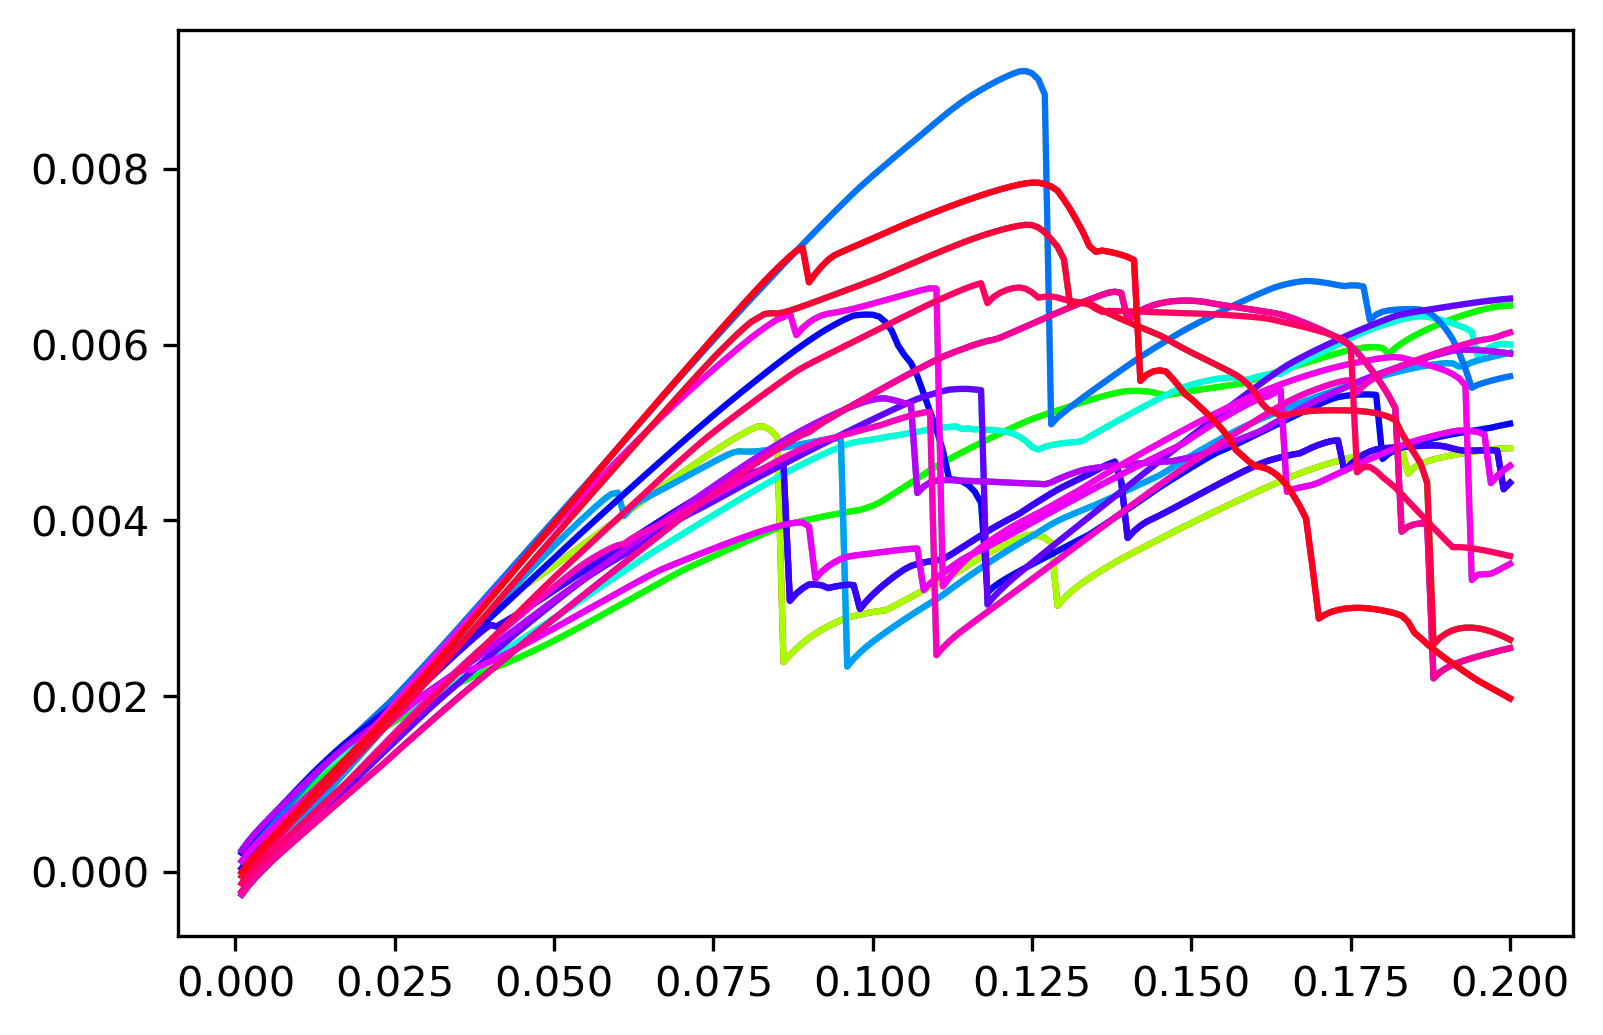

In [199]:
cmap = cm.hsv
norm = mpl.colors.Normalize(vmin=0, vmax=35)

plt.figure(dpi=150)

strain = np.linspace(0.001, 0.2, 200)

for i in range(len(angles)):
    plt.plot(strain, -virials[i,1:,1], color=cmap(norm(i)));

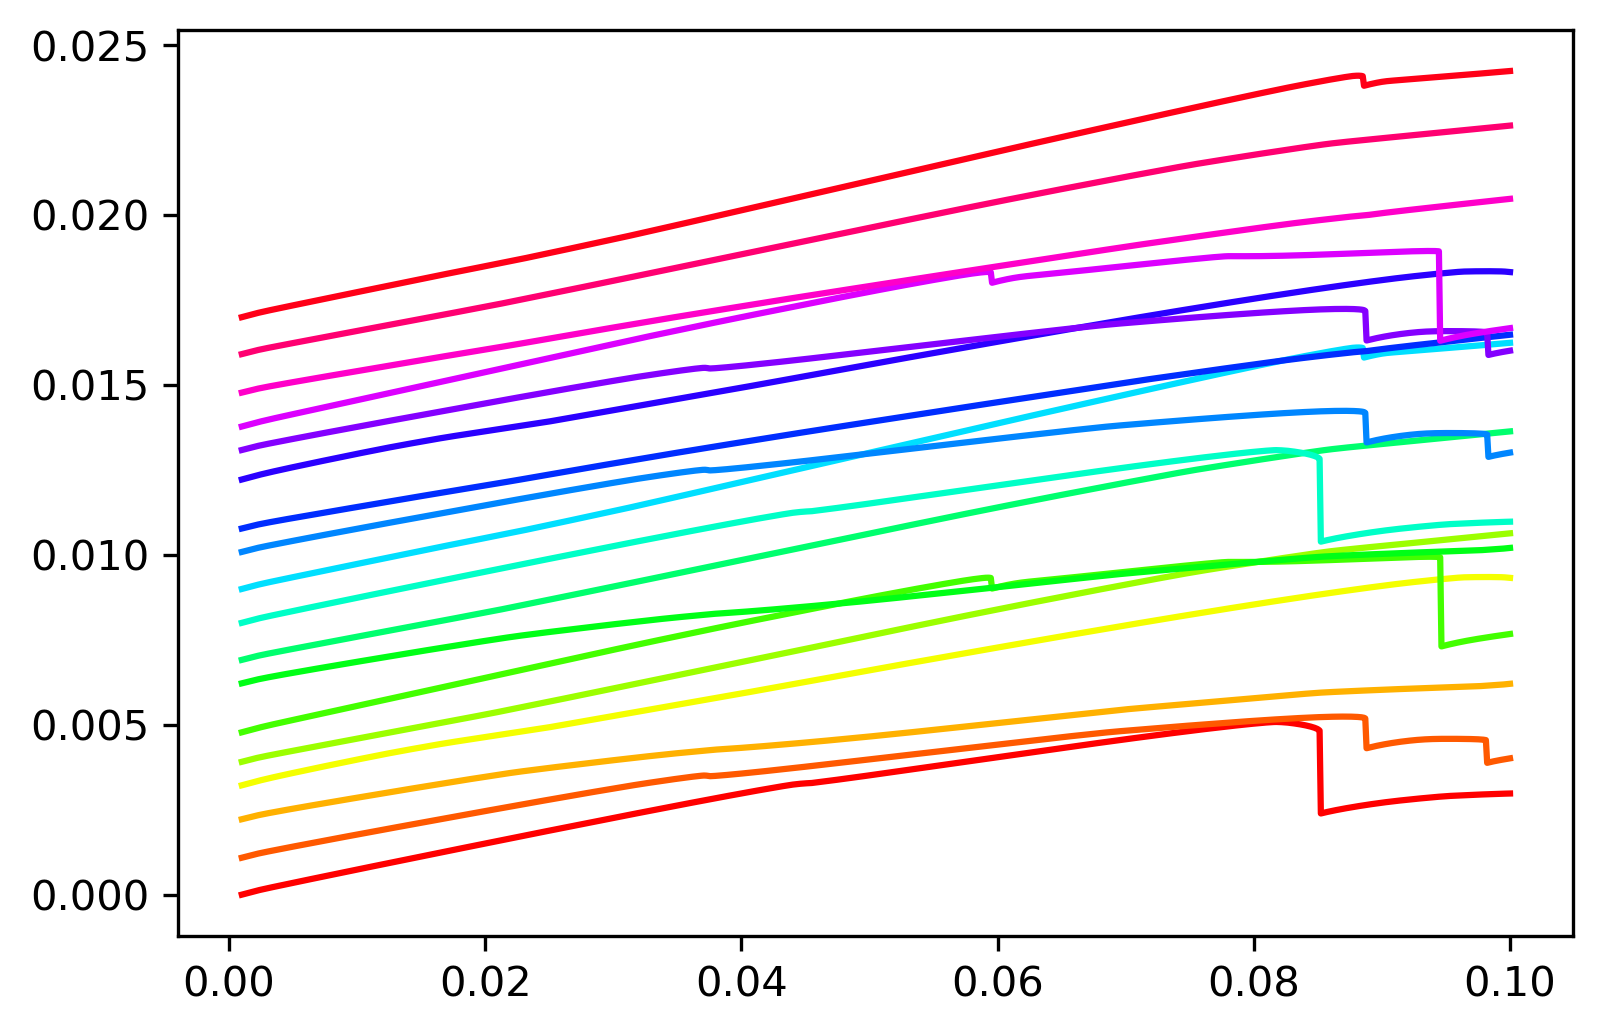

In [189]:
cmap = cm.hsv
norm = mpl.colors.Normalize(vmin=0, vmax=17)

plt.figure(dpi=150)

strain = np.linspace(0.001, 0.2, 200)

for i in range(len(angles)):
    plt.plot(strain, -virials[i,1:,1] + i*0.001, color=cmap(norm(i)));

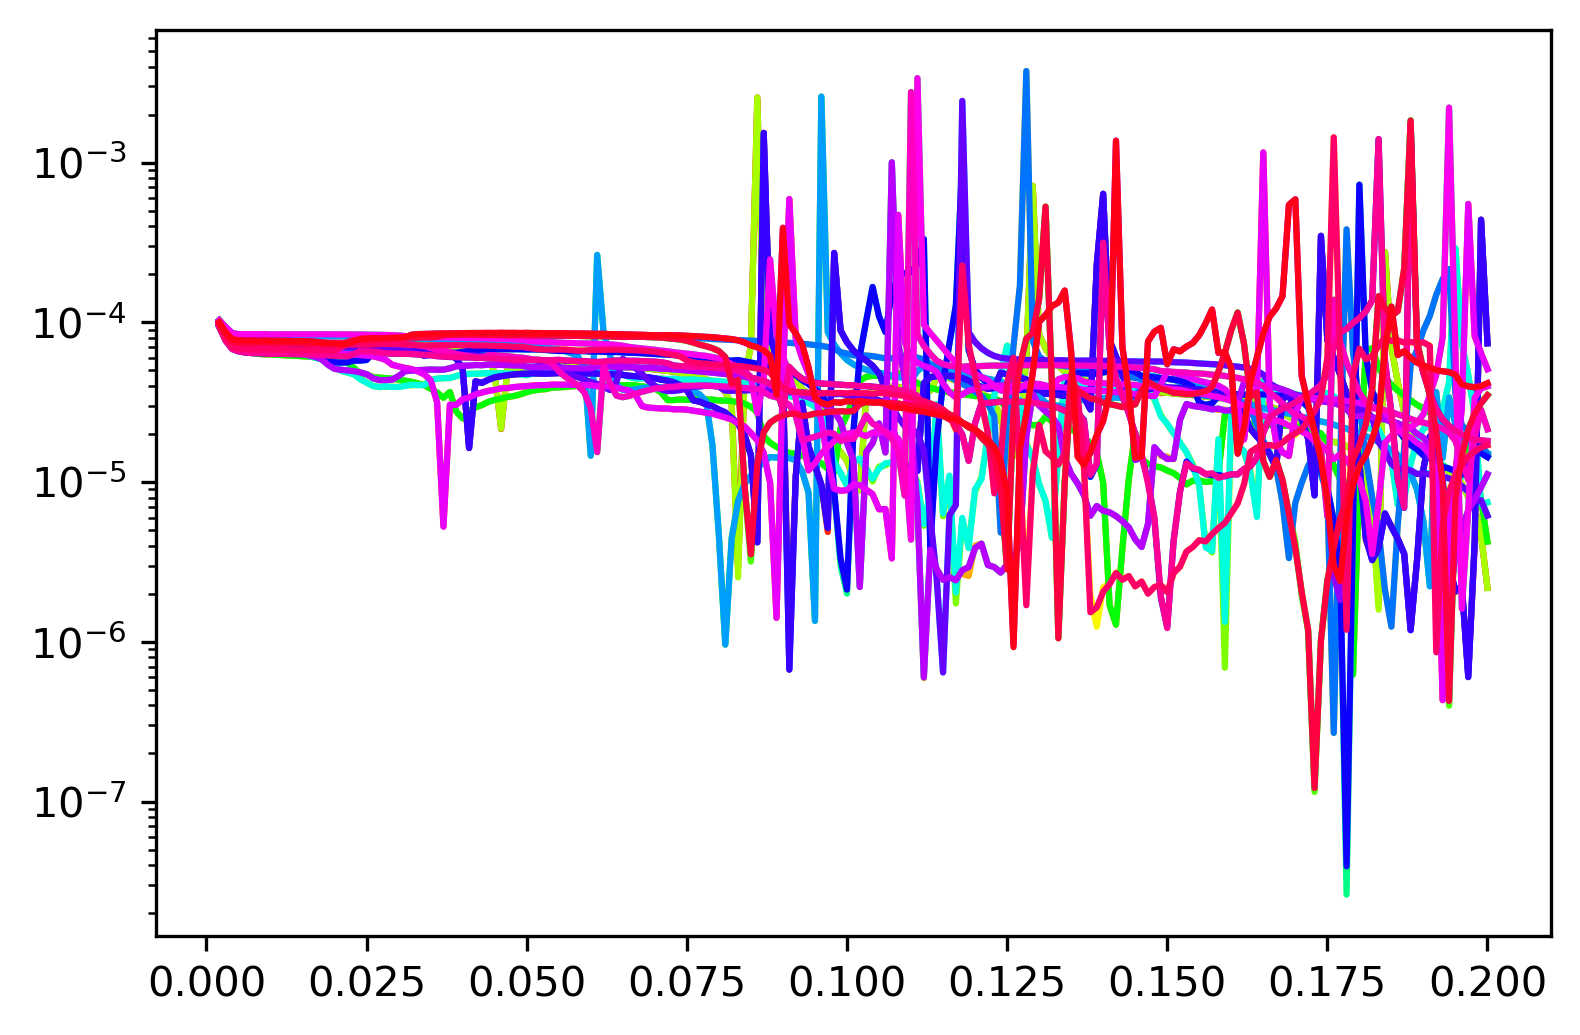

In [203]:
cmap = cm.hsv
norm = mpl.colors.Normalize(vmin=0, vmax=35)

plt.figure(dpi=150)

strain = np.linspace(0.002, 0.2, 199)

for i in range(len(angles)):
    plt.plot(strain, np.abs(np.diff(virials[i,1:,1], axis=0)), color=cmap(norm(i)));
plt.yscale('log')
# plt.ylim(1e-9, 1e-2)

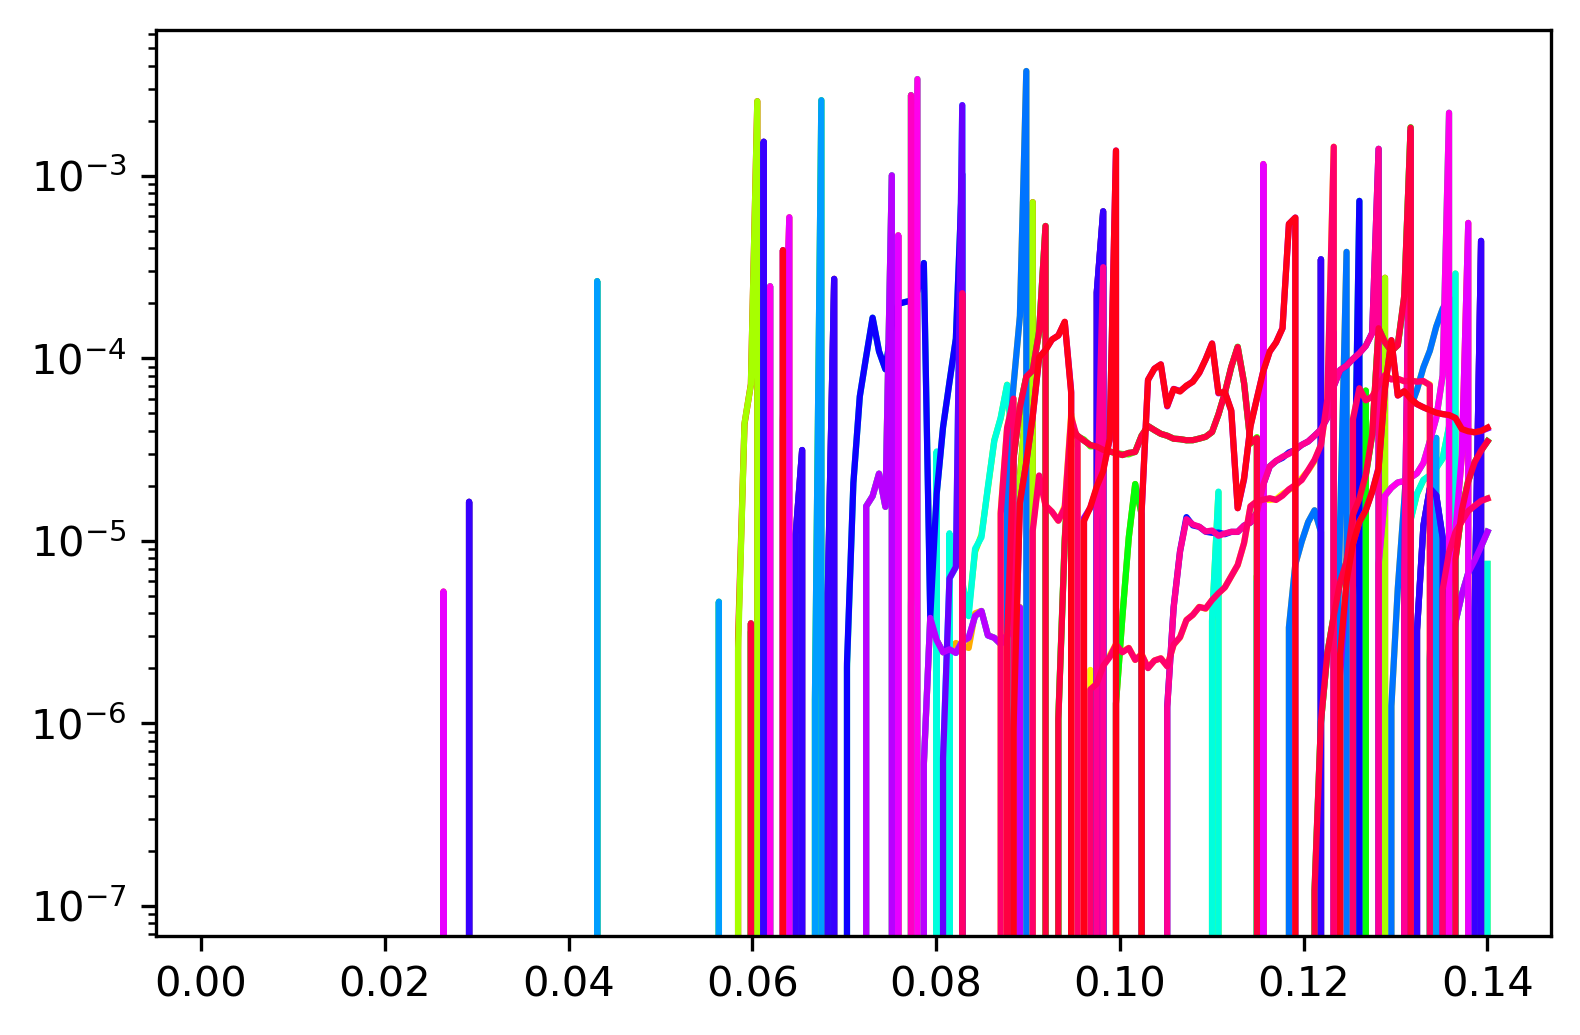

In [201]:
cmap = cm.hsv
norm = mpl.colors.Normalize(vmin=0, vmax=35)

plt.figure(dpi=150)

strain = np.linspace(0.002, 0.2, 199)

for i in range(len(angles)):
    plt.plot(strain, np.diff(virials[i,1:,1], axis=0), color=cmap(norm(i)));
plt.yscale('log')
# plt.ylim(1e-9, 1e-2)

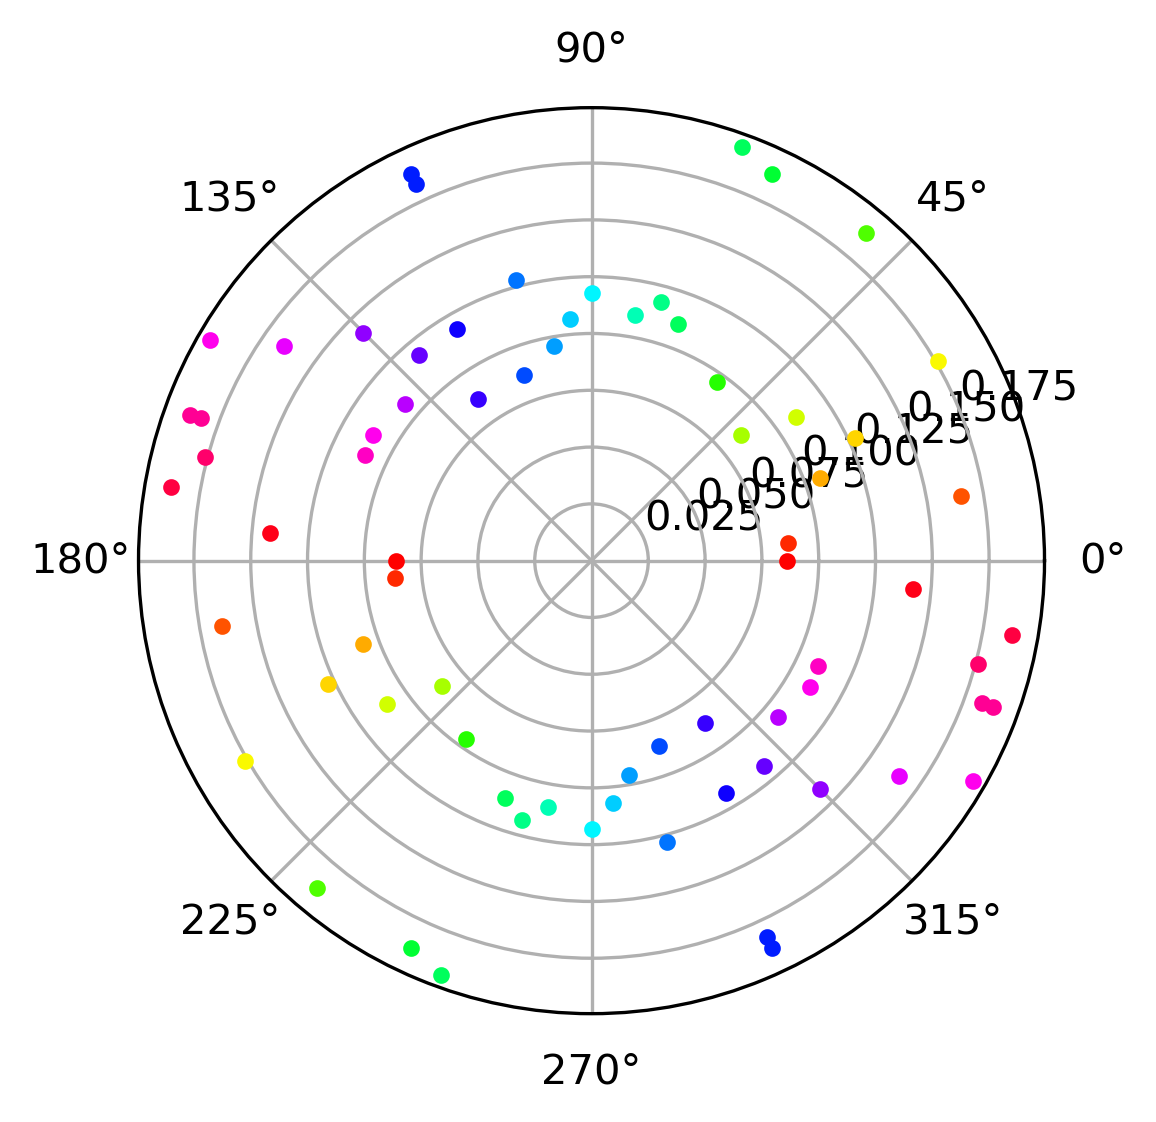

In [207]:
cmap = cm.hsv
norm = mpl.colors.Normalize(vmin=0, vmax=35)

strain = np.linspace(0.002, 0.2, 199)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, dpi=150)

for i in range(len(angles)):
    cond = np.diff(virials[i,1:,1], axis=0) > 1e-3
    y = strain[cond]
    plt.plot(i/36*np.pi*np.ones_like(y), y, ".", color=cmap(norm(i)));
    plt.plot((i+36)/36*np.pi*np.ones_like(y), y, ".", color=cmap(norm(i)));
# plt.yscale('log')
# plt.ylim(1e-9, 1e-2)

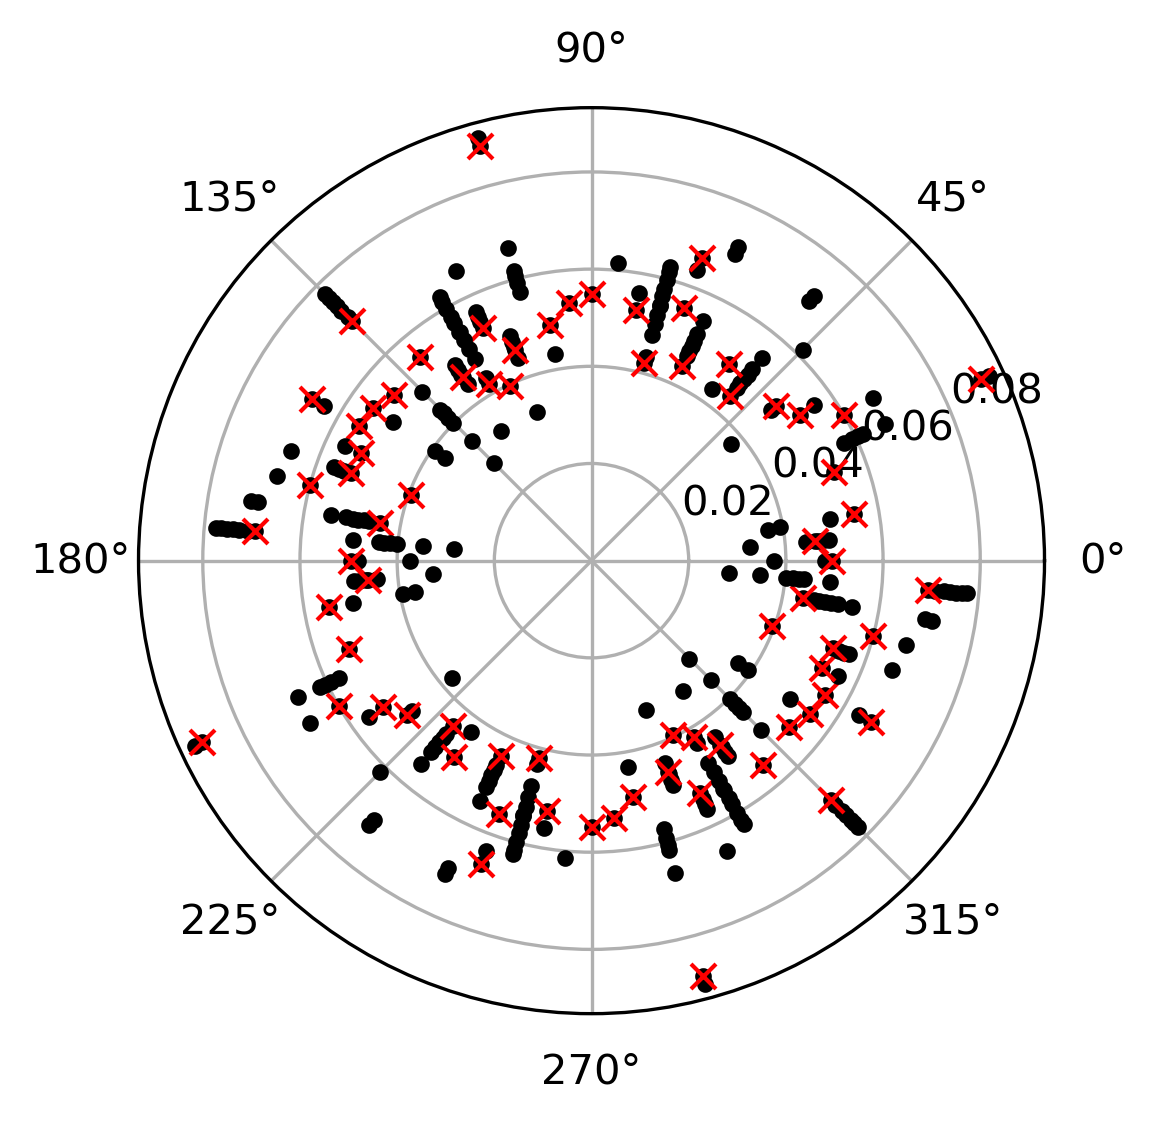

In [215]:
cmap = cm.hsv
norm = mpl.colors.Normalize(vmin=0, vmax=17)

strain = np.linspace(0.002, 0.2, 199)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, dpi=150)

for i in range(len(angles)):
    cond = (np.diff(virials[i,1:,1], axis=0) > 1e-4 ) & (strain > 0.01)
    if not np.any(cond):
        continue
    y = -virials[i,1:-1,1][cond]#[[0]]
    plt.plot(i/36*np.pi*np.ones_like(y), y*10, ".", color="k");
    plt.plot((i+36)/36*np.pi*np.ones_like(y), y*10, ".", color="k");

    cond = (np.diff(virials[i,1:,1], axis=0) > 1e-3 )
    if not np.any(cond):
        continue
    y = -virials[i,1:-1,1][cond]#[[0]]
    plt.plot(i/36*np.pi*np.ones_like(y), y*10, "x", color="r");
    plt.plot((i+36)/36*np.pi*np.ones_like(y), y*10, "x", color="r");
# plt.yscale('log')
# plt.ylim(1e-9, 1e-2)

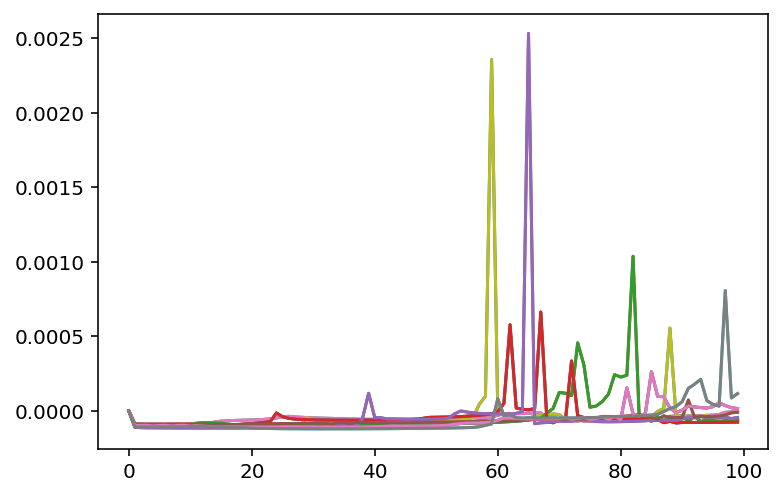

In [146]:
plt.plot(np.diff(virials[:,:,1], axis=1).T);

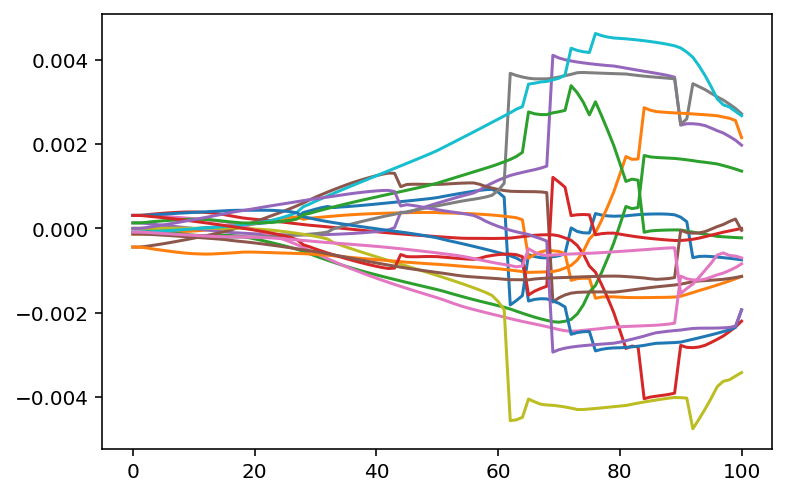

In [132]:
plt.plot(np.diff(virials[:,:,1], axis=0).T)

In [242]:
cut_snap = cut.to_snap(0, 0.0)

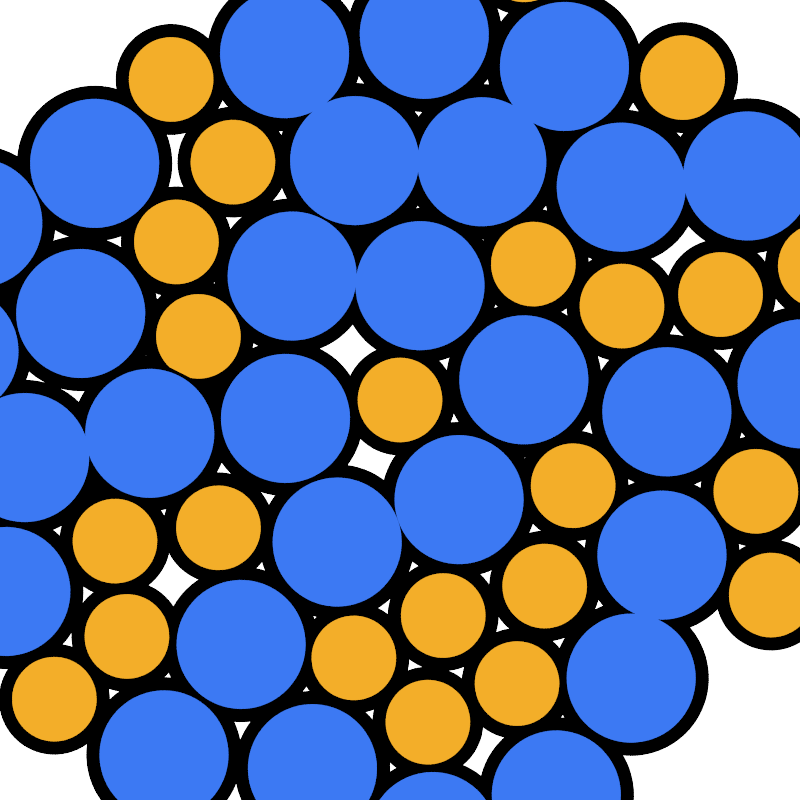

In [243]:
render.render_disk_frame(cut_snap)